# VAE for MNIST clustering and generation

The goal of this notebook is to explore some recent works dealing with variational auto-encoder (VAE).

We will use MNIST dataset and a basic VAE architecture. 

In [49]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [50]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [51]:
batch_size = 128
#to be modified
data_dir = '/Users/lawrence/Desktop/ENS/Year 1/DeepL/NEW_DEEPL/dataflowr/Notebooks/Data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

# Variational Autoencoders

Consider a latent variable model with a data variable $x\in \mathcal{X}$ and a latent variable $z\in \mathcal{Z}$, $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots, x_n$, we want to train the model by maximizing the marginal log-likelihood:
\begin{eqnarray*}
\mathcal{L} = \mathbf{E}_{p_d(x)}\left[\log p_\theta(x)\right]=\mathbf{E}_{p_d(x)}\left[\log \int_{\mathcal{Z}}p_{\theta}(x|z)p(z)dz\right],
  \end{eqnarray*}
  where $p_d$ denotes the empirical distribution of $X$: $p_d(x) =\frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

 To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instea maximize a lower bound to the log-likelihood:
  \begin{eqnarray*}
\mathcal{L} \geq L(p_\theta(x|z),q(z|x)) =\mathbf{E}_{p_d(x)}\left[\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]-\mathrm{KL}\left( q(z|x)||p(z)\right)\right].
  \end{eqnarray*}
  Any choice of $q(z|x)$ gives a valid lower bound. Variational autoencoders replace the variational posterior $q(z|x)$ by an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta,q_\phi)$. The variational posterior $q_{\phi}(z|x)$ is also called the encoder and the generative model $p_{\theta}(x|z)$, the decoder or generator.

The first term $\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$ is the negative reconstruction error. Indeed under a gaussian assumption i.e. $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), 1)$ the term $\log p_\theta(x|z)$ reduced to $\propto \|x-\mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left( q(z|x)||p(z)\right)$ can be seen as a regularization term, where the variational posterior $q_\phi(z|x)$ should be matched to the prior $p(z)= \mathcal{N}(0,1)$.

Variational Autoencoders were introduced by [Kingma and Welling](https://arxiv.org/abs/1312.6114), see also [Doersch](https://arxiv.org/abs/1606.05908) for a tutorial.

There are vairous examples of VAE in pytorch available [here](https://github.com/pytorch/examples/tree/master/vae) or [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py#L38-L65). The code below is taken from this last source.

In [52]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim) #Applies a linear transformation to the incoming data: y=xA^T+b 
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Here for the loss, instead of MSE for the reconstruction loss, we take BCE. The code below is still from the pytorch tutorial (with minor modifications to avoid warnings!).

In [53]:
# Start training
for epoch in range(num_epochs):
    
    #Size of x is [96,784]
    for i, (x, _) in enumerate(data_loader): 
        
        # _ is a tensor of the labels of size 128 i.e [1,1,3,9, ...] so 128 images 
        # x is a tensor of size [128, 1, 28, 28]
        
        
        # Forward pass
 
    
        x = x.to(device).view(-1, image_size)
        #size of x after the above command is [128,784]
        
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))

Epoch[1/15], Step [10/469], Reconst Loss: 278.7674, KL Div: 31.1810
Epoch[1/15], Step [20/469], Reconst Loss: 231.8969, KL Div: 8.3939
Epoch[1/15], Step [30/469], Reconst Loss: 213.3109, KL Div: 8.8828
Epoch[1/15], Step [40/469], Reconst Loss: 210.7527, KL Div: 5.6901
Epoch[1/15], Step [50/469], Reconst Loss: 200.5040, KL Div: 5.5920
Epoch[1/15], Step [60/469], Reconst Loss: 191.8600, KL Div: 7.4217
Epoch[1/15], Step [70/469], Reconst Loss: 191.4737, KL Div: 7.7230
Epoch[1/15], Step [80/469], Reconst Loss: 186.7929, KL Div: 8.7188
Epoch[1/15], Step [90/469], Reconst Loss: 179.3632, KL Div: 9.3732
Epoch[1/15], Step [100/469], Reconst Loss: 175.2883, KL Div: 9.8787
Epoch[1/15], Step [110/469], Reconst Loss: 168.8838, KL Div: 11.8138
Epoch[1/15], Step [120/469], Reconst Loss: 167.1773, KL Div: 12.6956
Epoch[1/15], Step [130/469], Reconst Loss: 160.8060, KL Div: 12.2048
Epoch[1/15], Step [140/469], Reconst Loss: 149.6658, KL Div: 13.7156
Epoch[1/15], Step [150/469], Reconst Loss: 149.4407,

Epoch[3/15], Step [290/469], Reconst Loss: 86.7691, KL Div: 23.3951
Epoch[3/15], Step [300/469], Reconst Loss: 82.6082, KL Div: 23.3239
Epoch[3/15], Step [310/469], Reconst Loss: 90.6798, KL Div: 23.9085
Epoch[3/15], Step [320/469], Reconst Loss: 94.2459, KL Div: 24.3870
Epoch[3/15], Step [330/469], Reconst Loss: 91.8116, KL Div: 23.7088
Epoch[3/15], Step [340/469], Reconst Loss: 85.7269, KL Div: 23.6281
Epoch[3/15], Step [350/469], Reconst Loss: 87.7845, KL Div: 23.7499
Epoch[3/15], Step [360/469], Reconst Loss: 90.8915, KL Div: 24.3111
Epoch[3/15], Step [370/469], Reconst Loss: 91.1308, KL Div: 23.8356
Epoch[3/15], Step [380/469], Reconst Loss: 91.4878, KL Div: 23.8456
Epoch[3/15], Step [390/469], Reconst Loss: 85.8265, KL Div: 23.6092
Epoch[3/15], Step [400/469], Reconst Loss: 89.2471, KL Div: 24.4133
Epoch[3/15], Step [410/469], Reconst Loss: 89.6886, KL Div: 23.1928
Epoch[3/15], Step [420/469], Reconst Loss: 90.8288, KL Div: 24.5802
Epoch[3/15], Step [430/469], Reconst Loss: 89.73

Epoch[6/15], Step [120/469], Reconst Loss: 83.8325, KL Div: 24.3427
Epoch[6/15], Step [130/469], Reconst Loss: 82.1422, KL Div: 25.4085
Epoch[6/15], Step [140/469], Reconst Loss: 84.1427, KL Div: 24.4281
Epoch[6/15], Step [150/469], Reconst Loss: 82.2865, KL Div: 25.3956
Epoch[6/15], Step [160/469], Reconst Loss: 86.6771, KL Div: 24.5540
Epoch[6/15], Step [170/469], Reconst Loss: 85.3587, KL Div: 24.8184
Epoch[6/15], Step [180/469], Reconst Loss: 82.2945, KL Div: 24.4167
Epoch[6/15], Step [190/469], Reconst Loss: 84.8265, KL Div: 24.2298
Epoch[6/15], Step [200/469], Reconst Loss: 80.6613, KL Div: 24.1565
Epoch[6/15], Step [210/469], Reconst Loss: 83.8964, KL Div: 25.3141
Epoch[6/15], Step [220/469], Reconst Loss: 82.1236, KL Div: 24.7236
Epoch[6/15], Step [230/469], Reconst Loss: 86.7416, KL Div: 25.4529
Epoch[6/15], Step [240/469], Reconst Loss: 83.1710, KL Div: 24.4920
Epoch[6/15], Step [250/469], Reconst Loss: 87.4360, KL Div: 25.6014
Epoch[6/15], Step [260/469], Reconst Loss: 86.68

Epoch[8/15], Step [410/469], Reconst Loss: 82.6191, KL Div: 24.1514
Epoch[8/15], Step [420/469], Reconst Loss: 78.2514, KL Div: 24.9306
Epoch[8/15], Step [430/469], Reconst Loss: 82.7360, KL Div: 25.3778
Epoch[8/15], Step [440/469], Reconst Loss: 83.2479, KL Div: 24.7862
Epoch[8/15], Step [450/469], Reconst Loss: 78.6996, KL Div: 25.3989
Epoch[8/15], Step [460/469], Reconst Loss: 87.6514, KL Div: 25.5586
Epoch[9/15], Step [10/469], Reconst Loss: 84.2288, KL Div: 24.8917
Epoch[9/15], Step [20/469], Reconst Loss: 85.6871, KL Div: 24.9779
Epoch[9/15], Step [30/469], Reconst Loss: 81.1966, KL Div: 25.5525
Epoch[9/15], Step [40/469], Reconst Loss: 81.0268, KL Div: 24.7835
Epoch[9/15], Step [50/469], Reconst Loss: 80.4823, KL Div: 24.8209
Epoch[9/15], Step [60/469], Reconst Loss: 82.9388, KL Div: 25.9364
Epoch[9/15], Step [70/469], Reconst Loss: 83.1414, KL Div: 25.0653
Epoch[9/15], Step [80/469], Reconst Loss: 83.6958, KL Div: 25.5369
Epoch[9/15], Step [90/469], Reconst Loss: 80.2287, KL Di

Epoch[11/15], Step [230/469], Reconst Loss: 80.6915, KL Div: 24.9934
Epoch[11/15], Step [240/469], Reconst Loss: 76.2709, KL Div: 24.2352
Epoch[11/15], Step [250/469], Reconst Loss: 80.9064, KL Div: 25.0731
Epoch[11/15], Step [260/469], Reconst Loss: 77.8199, KL Div: 25.1904
Epoch[11/15], Step [270/469], Reconst Loss: 80.0051, KL Div: 24.1816
Epoch[11/15], Step [280/469], Reconst Loss: 78.0546, KL Div: 25.2758
Epoch[11/15], Step [290/469], Reconst Loss: 82.1518, KL Div: 24.5482
Epoch[11/15], Step [300/469], Reconst Loss: 75.8702, KL Div: 25.3700
Epoch[11/15], Step [310/469], Reconst Loss: 81.2765, KL Div: 24.8885
Epoch[11/15], Step [320/469], Reconst Loss: 81.2262, KL Div: 25.1274
Epoch[11/15], Step [330/469], Reconst Loss: 83.3690, KL Div: 24.9778
Epoch[11/15], Step [340/469], Reconst Loss: 78.2288, KL Div: 24.8544
Epoch[11/15], Step [350/469], Reconst Loss: 79.3988, KL Div: 23.8379
Epoch[11/15], Step [360/469], Reconst Loss: 84.8900, KL Div: 25.9095
Epoch[11/15], Step [370/469], Reco

Epoch[14/15], Step [50/469], Reconst Loss: 79.5841, KL Div: 25.5934
Epoch[14/15], Step [60/469], Reconst Loss: 80.1902, KL Div: 25.5091
Epoch[14/15], Step [70/469], Reconst Loss: 79.5284, KL Div: 25.7998
Epoch[14/15], Step [80/469], Reconst Loss: 82.9711, KL Div: 25.0229
Epoch[14/15], Step [90/469], Reconst Loss: 79.2261, KL Div: 24.6471
Epoch[14/15], Step [100/469], Reconst Loss: 79.5365, KL Div: 24.7276
Epoch[14/15], Step [110/469], Reconst Loss: 80.4120, KL Div: 25.5368
Epoch[14/15], Step [120/469], Reconst Loss: 78.6338, KL Div: 25.1858
Epoch[14/15], Step [130/469], Reconst Loss: 79.1474, KL Div: 24.5064
Epoch[14/15], Step [140/469], Reconst Loss: 78.2530, KL Div: 25.3869
Epoch[14/15], Step [150/469], Reconst Loss: 78.0455, KL Div: 24.1258
Epoch[14/15], Step [160/469], Reconst Loss: 78.8403, KL Div: 26.7219
Epoch[14/15], Step [170/469], Reconst Loss: 78.7131, KL Div: 24.5017
Epoch[14/15], Step [180/469], Reconst Loss: 77.7683, KL Div: 24.8306
Epoch[14/15], Step [190/469], Reconst L

Let see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version.

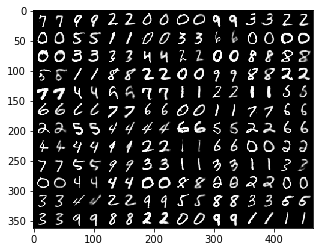

In [54]:
mu, _ = model.encode(x) 
out = model.decode(mu)
x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
out_grid = torchvision.utils.make_grid(x_concat).cpu().data
show(out_grid)

Let see now, how our network generates new samples.

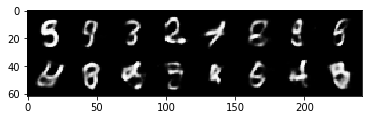

In [55]:
with torch.no_grad():
        z = torch.randn(16, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

out_grid = torchvision.utils.make_grid(out).cpu()
show(out_grid)

Not great, but we did not train our network for long... That being said, we have no control of the generated digits. In the rest of this jupyter, we explore ways to generates zeros, ones, twos and so on. As a by product, we show how our VAE will allow us to do clustering.

The main idea is to build what we call a Gumbel VAE as described below.

# Gumbel VAE

Implement a VAE where you add a categorical variable $c\in \{0,\dots 9\}$ so that your latent variable model is $p(c,z,x) = p(c)p(z)p_{\theta}(x|,c,z)$ and your variational posterior is $q_{\phi}(c|x)q_{\phi}(z|x)$ as described in this NIPS [paper](https://arxiv.org/abs/1804.00104). Make minimal modifications to previous architecture...

The idea is that you incorporates a categorical variable in your latent space. You hope that this categorical variable will encode the class of the digit, so that your network can use it for a better reconstruction. Moreover, if things work as planed, you will then be able to generate digits conditionally to the class, i.e. you can choose the class thanks to the latent categorical variable $c$ and then generate digits from this class.

As noticed above, in order to sample random variables while still being able to use backpropagation required us to use the reparameterization trick which is easy for Gaussian random variables. For categorical random variables, the reparameterization trick is explained in this [paper](https://arxiv.org/abs/1611.01144). This is implemented in pytorch thanks to [F.gumbel_softmax](https://pytorch.org/docs/stable/nn.html?highlight=gumbel_softmax#torch.nn.functional.gumbel_softmax)

In [56]:
n_classes = 10

class VAE_Gumbel(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, n_classes = 10):
        super(VAE_Gumbel, self).__init__()
        
        #Here we define the architecture of the network.
        
        # nn.Linear applies a linear transformation to the incoming data: y=xA^T+b 
        
        #encoder structure
        self.fc1 = nn.Linear(image_size, h_dim)  #for the initial mapping z -> h
        self.fc2 = nn.Linear(h_dim, z_dim) # for the mapping h -> mu
        self.fc3 = nn.Linear(h_dim, z_dim) # for the mapping h -> sigma 
        self.fca = nn.Linear (h_dim,n_classes) # for the mapping h -> alpha
        
        #inbetween there will be sampling and concatenation:
        
        #decoder structure
        self.fc4 = nn.Linear(z_dim+n_classes, h_dim) #for the mapping zc -> h' 
        self.fc5 = nn.Linear(h_dim, image_size) #for the mapping h' -> x
        
        
        
    def encode(self, x):
        #use F.log_softmax
        
        h = F.relu(self.fc1(x))
        alpha =self.fca(h)  #this actually isnt alpha is approx logalpha due to the trick
        alpha=F.log_softmax(alpha)
        return self.fc2(h), self.fc3(h), alpha
        
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y_onehot):
        #
        z_concat=torch.cat((z,y_onehot),1)
        h = F.relu(self.fc4(z_concat))        
        return torch.sigmoid(self.fc5(h))  
        #
        
    
    def forward(self, x):
        
        #/ use F.gumbel_softmax 
        
        
        mu, log_var,alpha = self.encode(x)
        #here we draw alpha from gumble softmax with parameter alpha
        c= F.gumbel_softmax(alpha) 
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z,c)
        return x_reconst, mu, log_var,c 
        

model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

You need to modify the loss to take into account the categorical random variable with an uniform prior on $\{0,\dots 9\}$, see Appendix A.2 in the NIPS [paper](https://arxiv.org/abs/1804.00104)

In [57]:
def train_G(model, data_loader=data_loader,num_epochs=num_epochs, beta = 1., verbose=True):
    nmi_scores = []
    model.train(True)
    
    #initialise the buffer described in the paper for the KL divergance:
#     buffer=np.linspace(0,5,len(data_loader))
    
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            #
           
        
            x_reconst, mu, log_var,c = model(x)
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            
            
          #minimise kl div, hence maximise negative kl
            kl_div_qz_given_pz = 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            #want to maximise the entropy hence minimise - entropy
            kl_div_qc_given_pc = torch.sum(-c*torch.exp(c))
        
            
            
            # in origional paper they use a buffer Uncomment below 
            
            #minimise both kl divergance
            
            #buffer:
#             kl_div = abs(kl_div_qz_given_pz-buffer[i])+abs(kl_div_qc_given_pc-buffer[i])

            #normal method

            kl_div = -kl_div_qz_given_pz-kl_div_qc_given_pc
            
            loss = reconst_loss +kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))
             


In [59]:
train_G(model_G,num_epochs=5,verbose=True)

/Users/lawrence/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch[1/5], Step [10/469], Reconst Loss: 294.0756, KL Div: 34.8787
Epoch[1/5], Step [20/469], Reconst Loss: 231.4767, KL Div: 11.9589
Epoch[1/5], Step [30/469], Reconst Loss: 209.4350, KL Div: 11.0578
Epoch[1/5], Step [40/469], Reconst Loss: 212.1874, KL Div: 8.0829
Epoch[1/5], Step [50/469], Reconst Loss: 204.2047, KL Div: 6.9824
Epoch[1/5], Step [60/469], Reconst Loss: 200.2710, KL Div: 7.9747
Epoch[1/5], Step [70/469], Reconst Loss: 188.7476, KL Div: 9.8702
Epoch[1/5], Step [80/469], Reconst Loss: 176.0343, KL Div: 11.7348
Epoch[1/5], Step [90/469], Reconst Loss: 169.7260, KL Div: 12.9970
Epoch[1/5], Step [100/469], Reconst Loss: 166.2397, KL Div: 13.1369
Epoch[1/5], Step [110/469], Reconst Loss: 169.0806, KL Div: 14.0029
Epoch[1/5], Step [120/469], Reconst Loss: 155.7763, KL Div: 14.7812
Epoch[1/5], Step [130/469], Reconst Loss: 162.1218, KL Div: 14.4763
Epoch[1/5], Step [140/469], Reconst Loss: 150.8644, KL Div: 15.6988
Epoch[1/5], Step [150/469], Reconst Loss: 148.6415, KL Div: 1

Epoch[3/5], Step [310/469], Reconst Loss: 86.5174, KL Div: 25.2779
Epoch[3/5], Step [320/469], Reconst Loss: 90.7974, KL Div: 26.0219
Epoch[3/5], Step [330/469], Reconst Loss: 89.7219, KL Div: 24.5214
Epoch[3/5], Step [340/469], Reconst Loss: 92.2675, KL Div: 25.7422
Epoch[3/5], Step [350/469], Reconst Loss: 87.4697, KL Div: 25.6714
Epoch[3/5], Step [360/469], Reconst Loss: 87.5224, KL Div: 24.7462
Epoch[3/5], Step [370/469], Reconst Loss: 86.4940, KL Div: 24.5718
Epoch[3/5], Step [380/469], Reconst Loss: 92.0103, KL Div: 25.4818
Epoch[3/5], Step [390/469], Reconst Loss: 90.0497, KL Div: 25.4110
Epoch[3/5], Step [400/469], Reconst Loss: 91.2677, KL Div: 26.1354
Epoch[3/5], Step [410/469], Reconst Loss: 88.1924, KL Div: 25.2346
Epoch[3/5], Step [420/469], Reconst Loss: 90.4532, KL Div: 25.7873
Epoch[3/5], Step [430/469], Reconst Loss: 90.3264, KL Div: 25.0678
Epoch[3/5], Step [440/469], Reconst Loss: 88.0474, KL Div: 24.3726
Epoch[3/5], Step [450/469], Reconst Loss: 87.5168, KL Div: 26.

In [ ]:
x,_ = next(iter(data_loader))
x = x[:24,:,:,:].to(device)
out, _, _, log_p = model_G(x.view(-1, image_size)) 
x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
out_grid = torchvision.utils.make_grid(x_concat).cpu().data
show(out_grid)

This was for reconstruction, but we care more about generation. For each category, we are generating 8 samples thanks to the following matrix, so that in the end, we should have on each line only one digit represented.

In [ ]:
matrix = np.zeros((8,n_classes))
matrix[:,0] = 1
final = matrix[:]
for i in range(1,n_classes):
    final = np.vstack((final,np.roll(matrix,i)))

In [ ]:
with torch.no_grad():
        z = torch.randn(8*n_classes, z_dim).to(device)
        y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
        out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)

out_grid = torchvision.utils.make_grid(out).cpu()
show(out_grid)

It does not look like our original idea is working...

To check that our network is not using the categorical variable, we can track the [normalized mutual information](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html) between the true labels and the labels 'predicted' by our network (just by taking the category with maximal probability). Change your training loop to return the normalized mutual information (NMI) for each epoch. Plot the curve to check that the NMI is actually decreasing.

In [85]:
import sklearn.metrics

In [86]:
def train_G_nmi(model, data_loader=data_loader,num_epochs=num_epochs, beta = 1., verbose=True):
    nmi_scores = []
    model.train(True)
    
    #initialise the buffer described in the paper for the KL divergance:
    buffer=np.linspace(0,5,len(data_loader))
    
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            #
           
        
            x_reconst, mu, log_var,c = model(x)
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
          
            kl_div_qz_given_pz = 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            kl_div_qc_given_pc = torch.sum(-c*torch.exp(c))
            
         

            kl_div = -kl_div_qz_given_pz-kl_div_qc_given_pc
        
     
            loss = reconst_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        

            if (i+1) % 10 == 0:
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))
       
        
            _,argmaxs =torch.max(c,1)
            lab_list=labels.numpy().tolist()
            argmax_list=argmaxs.numpy().tolist()
            all_labels=all_labels+lab_list
            all_labels_est=all_labels_est+argmax_list
            
       

        nmi_ep=sklearn.metrics.normalized_mutual_info_score(all_labels,all_labels_est)
        nmi_scores.append(nmi_ep)
        
        
        
        
    return nmi_scores


In [87]:
nmis=train_G_nmi(model_G,num_epochs=5,verbose=True)

/Users/lawrence/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch[1/5], Step [10/469], Reconst Loss: 159.9441, KL Div: 2.4567
Epoch[1/5], Step [20/469], Reconst Loss: 151.6967, KL Div: 2.9964
Epoch[1/5], Step [30/469], Reconst Loss: 159.0759, KL Div: 3.8149
Epoch[1/5], Step [40/469], Reconst Loss: 150.5442, KL Div: 4.4258
Epoch[1/5], Step [50/469], Reconst Loss: 143.3532, KL Div: 5.2016
Epoch[1/5], Step [60/469], Reconst Loss: 139.0869, KL Div: 6.1269
Epoch[1/5], Step [70/469], Reconst Loss: 134.0853, KL Div: 6.8517
Epoch[1/5], Step [80/469], Reconst Loss: 133.8643, KL Div: 7.8787
Epoch[1/5], Step [90/469], Reconst Loss: 132.3585, KL Div: 9.0826
Epoch[1/5], Step [100/469], Reconst Loss: 128.2648, KL Div: 9.7606
Epoch[1/5], Step [110/469], Reconst Loss: 128.0800, KL Div: 10.3591
Epoch[1/5], Step [120/469], Reconst Loss: 124.1108, KL Div: 11.4264
Epoch[1/5], Step [130/469], Reconst Loss: 123.1857, KL Div: 11.6473
Epoch[1/5], Step [140/469], Reconst Loss: 116.1900, KL Div: 11.6154
Epoch[1/5], Step [150/469], Reconst Loss: 116.4208, KL Div: 12.5113

Epoch[3/5], Step [320/469], Reconst Loss: 93.8947, KL Div: 20.4717
Epoch[3/5], Step [330/469], Reconst Loss: 91.6724, KL Div: 20.5027
Epoch[3/5], Step [340/469], Reconst Loss: 89.7937, KL Div: 21.4400
Epoch[3/5], Step [350/469], Reconst Loss: 88.6043, KL Div: 20.3462
Epoch[3/5], Step [360/469], Reconst Loss: 90.2765, KL Div: 20.6674
Epoch[3/5], Step [370/469], Reconst Loss: 89.9812, KL Div: 21.0410
Epoch[3/5], Step [380/469], Reconst Loss: 88.5557, KL Div: 21.2666
Epoch[3/5], Step [390/469], Reconst Loss: 86.5738, KL Div: 20.6117
Epoch[3/5], Step [400/469], Reconst Loss: 96.6033, KL Div: 20.3367
Epoch[3/5], Step [410/469], Reconst Loss: 90.3941, KL Div: 20.0856
Epoch[3/5], Step [420/469], Reconst Loss: 95.5682, KL Div: 21.2922
Epoch[3/5], Step [430/469], Reconst Loss: 90.5552, KL Div: 20.4456
Epoch[3/5], Step [440/469], Reconst Loss: 90.9243, KL Div: 20.6345
Epoch[3/5], Step [450/469], Reconst Loss: 92.8338, KL Div: 20.4086
Epoch[3/5], Step [460/469], Reconst Loss: 88.7618, KL Div: 20.

Text(0.5,1,'NMI throughout traning epochs ')

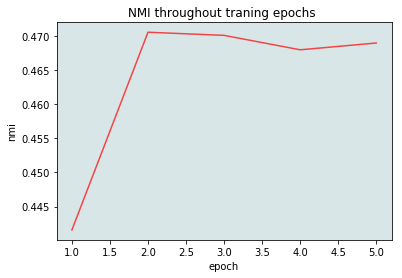

In [88]:
plt.plot(np.arange(1,len(nmis)+1,1),nmis,alpha=0.7,color='r')
ax = plt.gca()
ax.set_facecolor('#D9E6E8')
plt.xlabel("epoch")
plt.ylabel("nmi")
plt.title("NMI throughout traning epochs ")


In order to force our network to use the categorical variable, we will change the loss following this ICLR [paper](https://openreview.net/forum?id=Sy2fzU9gl)

Implement this change in the training loop and plot the new NMI curve after 10 epochs. For $\beta = 20$, you should see that NMI increases. But reconstruction starts to be bad and generation is still poor.

This is explained in this [paper](https://arxiv.org/abs/1804.03599) and a solution is proposed see Section 5. Implement the solution described in Section 3 equation (7) if the NIPS [paper](https://arxiv.org/abs/1804.00104) 

In [89]:
model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

In [90]:
def train_G_modified_loss(model,  beta , C_z_fin, C_c_fin, data_loader=data_loader,num_epochs=num_epochs, verbose=True):
    
    nmi_scores = []
    model.train(True)
    
    #initialise the buffer described in the paper for the KL divergance:
    bufferz=np.linspace(0,C_z_fin,len(data_loader))
    bufferc=np.linspace(0,C_c_fin,len(data_loader))
    
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            #
           
        
            x_reconst, mu, log_var,c = model(x)
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
          
            kl_div_qz_given_pz = 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            kl_div_qc_given_pc = torch.sum(-c*torch.exp(c))
            
         
            #new improved kl divergance
            kl_div = abs(kl_div_qz_given_pz-bufferz[i])+abs(kl_div_qc_given_pc-bufferc[i])
        
     
            loss = reconst_loss + beta*kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        

            if (i+1) % 10 == 0:
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))
       
        
            _,argmaxs =torch.max(c,1)
            lab_list=labels.numpy().tolist()
            argmax_list=argmaxs.numpy().tolist()
            all_labels=all_labels+lab_list
            all_labels_est=all_labels_est+argmax_list
            
        #at each epoch add the nmi scores into the list:

        nmi_ep=sklearn.metrics.normalized_mutual_info_score(all_labels,all_labels_est)
        nmi_scores.append(nmi_ep)
        
        
        
    return nmi_scores



In [91]:
nmis=train_G_modified_loss(model_G,beta=20,C_z_fin=5,C_c_fin=5,num_epochs=8,verbose=True)

/Users/lawrence/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch[1/8], Step [10/469], Reconst Loss: 362.3281, KL Div: 1.9075
Epoch[1/8], Step [20/469], Reconst Loss: 262.1651, KL Div: 1.8535
Epoch[1/8], Step [30/469], Reconst Loss: 235.8451, KL Div: 1.6155
Epoch[1/8], Step [40/469], Reconst Loss: 220.7850, KL Div: 1.5478
Epoch[1/8], Step [50/469], Reconst Loss: 214.2114, KL Div: 1.5175
Epoch[1/8], Step [60/469], Reconst Loss: 212.4047, KL Div: 1.4411
Epoch[1/8], Step [70/469], Reconst Loss: 209.6038, KL Div: 1.5316
Epoch[1/8], Step [80/469], Reconst Loss: 206.5115, KL Div: 1.4701
Epoch[1/8], Step [90/469], Reconst Loss: 214.7489, KL Div: 1.5500
Epoch[1/8], Step [100/469], Reconst Loss: 210.8383, KL Div: 1.5100
Epoch[1/8], Step [110/469], Reconst Loss: 215.8593, KL Div: 1.5083
Epoch[1/8], Step [120/469], Reconst Loss: 209.3651, KL Div: 1.5212
Epoch[1/8], Step [130/469], Reconst Loss: 212.4497, KL Div: 1.4766
Epoch[1/8], Step [140/469], Reconst Loss: 207.8003, KL Div: 1.5158
Epoch[1/8], Step [150/469], Reconst Loss: 208.4460, KL Div: 1.4997
Epoc

Epoch[3/8], Step [320/469], Reconst Loss: 179.7264, KL Div: 1.8499
Epoch[3/8], Step [330/469], Reconst Loss: 176.3720, KL Div: 1.8190
Epoch[3/8], Step [340/469], Reconst Loss: 176.2253, KL Div: 1.8109
Epoch[3/8], Step [350/469], Reconst Loss: 182.2447, KL Div: 1.8126
Epoch[3/8], Step [360/469], Reconst Loss: 175.4197, KL Div: 1.8602
Epoch[3/8], Step [370/469], Reconst Loss: 172.6780, KL Div: 1.8680
Epoch[3/8], Step [380/469], Reconst Loss: 170.7669, KL Div: 1.8679
Epoch[3/8], Step [390/469], Reconst Loss: 177.8948, KL Div: 1.8415
Epoch[3/8], Step [400/469], Reconst Loss: 180.5176, KL Div: 1.9249
Epoch[3/8], Step [410/469], Reconst Loss: 172.8007, KL Div: 1.9451
Epoch[3/8], Step [420/469], Reconst Loss: 176.2637, KL Div: 1.8487
Epoch[3/8], Step [430/469], Reconst Loss: 166.1832, KL Div: 1.8526
Epoch[3/8], Step [440/469], Reconst Loss: 177.8227, KL Div: 1.9345
Epoch[3/8], Step [450/469], Reconst Loss: 172.3547, KL Div: 1.8631
Epoch[3/8], Step [460/469], Reconst Loss: 168.7334, KL Div: 1.

Epoch[6/8], Step [170/469], Reconst Loss: 162.9741, KL Div: 1.8765
Epoch[6/8], Step [180/469], Reconst Loss: 166.5949, KL Div: 1.8498
Epoch[6/8], Step [190/469], Reconst Loss: 164.3617, KL Div: 1.8839
Epoch[6/8], Step [200/469], Reconst Loss: 163.5063, KL Div: 1.9139
Epoch[6/8], Step [210/469], Reconst Loss: 157.9837, KL Div: 1.9263
Epoch[6/8], Step [220/469], Reconst Loss: 171.9144, KL Div: 1.9434
Epoch[6/8], Step [230/469], Reconst Loss: 166.6199, KL Div: 1.8829
Epoch[6/8], Step [240/469], Reconst Loss: 167.8065, KL Div: 1.9048
Epoch[6/8], Step [250/469], Reconst Loss: 158.8328, KL Div: 1.9374
Epoch[6/8], Step [260/469], Reconst Loss: 162.3114, KL Div: 1.9373
Epoch[6/8], Step [270/469], Reconst Loss: 161.8105, KL Div: 1.8749
Epoch[6/8], Step [280/469], Reconst Loss: 163.2108, KL Div: 1.9407
Epoch[6/8], Step [290/469], Reconst Loss: 160.0231, KL Div: 1.9775
Epoch[6/8], Step [300/469], Reconst Loss: 169.4629, KL Div: 1.9386
Epoch[6/8], Step [310/469], Reconst Loss: 165.9367, KL Div: 1.

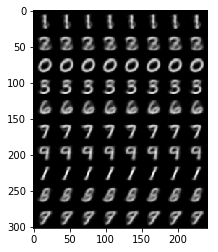

In [92]:
with torch.no_grad():
        z = torch.randn(8*n_classes, z_dim).to(device)
        y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
        out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)
out_grid = torchvision.utils.make_grid(out).cpu()
show(out_grid)

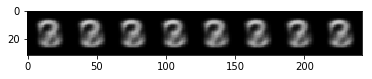

In [93]:
i = 1
with torch.no_grad():
    plt.plot()
    z = torch.randn(8, z_dim).to(device)
    y_onehot = torch.tensor(np.roll(matrix,i)).type(torch.FloatTensor).to(device)
    out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)
    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

/Users/lawrence/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


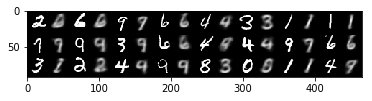

In [94]:
x,_ = next(iter(data_loader))
x = x[:24,:,:,:].to(device)
out, _, _, log_p = model_G(x.view(-1, image_size)) 
x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
out_grid = torchvision.utils.make_grid(x_concat).cpu().data
show(out_grid)

Text(0.5,1,'NMI throughout traning epochs ')

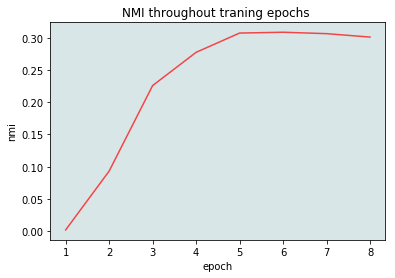

In [95]:
#in addition lets plot the nmis 
plt.plot(np.arange(1,len(nmis)+1,1),nmis,alpha=0.7,color='r')
ax = plt.gca()
ax.set_facecolor('#D9E6E8')
plt.xlabel("epoch")
plt.ylabel("nmi")
plt.title("NMI throughout traning epochs ")


In [96]:
#as we can see NMI is increasing as expected !